In [1]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import skew
import pgeocode

In [2]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
db = sqlite3.connect('home_sales.db')
df = pd.read_sql_query('SELECT * FROM sales;',db)

In [4]:
# dropping null values
df = df.dropna()

In [5]:
# feature engineering place_name from zipcode
nomi = pgeocode.Nominatim('us')
for index, row in df.iterrows():
    locObj = nomi.query_postal_code(int(row['zipcode']))
    df.loc[index,'place_name'] = locObj.place_name
df = df.replace({'place_name': {'Auburn':1,'Federal Way':2,'Kent':3,'Enumclaw':4,'Maple Valley':5,'Renton':6,'Black Diamond':7,'North Bend':8,'Duvall':9,'Carnation':10,'Kenmore':11,'Seattle':12,'Fall City':13,'Bothell':14,'Vashon':15,'Snoqualmie':16,'Kirkland':17,'Issaquah':18,'Woodinville':19,'Redmond':20,'Sammamish':21,'Bellevue':22,'Mercer Island':23,'Medina':24}
})

In [6]:
# relabel condition feature
df.loc[df.condition == 'TERRIBLE'] = df.loc[df.condition == 'TERRIBLE'].replace("TERRIBLE","0")
df.loc[df.condition == 'terrible'] = df.loc[df.condition == 'terrible'].replace("terrible","0")
df.loc[df.condition == 'POOR'] = df.loc[df.condition == 'POOR'].replace("POOR","1")
df.loc[df.condition == 'poor'] = df.loc[df.condition == 'poor'].replace("poor","1")
df.loc[df.condition == 'FAIR'] = df.loc[df.condition == 'FAIR'].replace("FAIR","2")
df.loc[df.condition == 'fair'] = df.loc[df.condition == 'fair'].replace("fair","2")
df.loc[df.condition == 'GOOD'] = df.loc[df.condition == 'GOOD'].replace("GOOD","3")
df.loc[df.condition == 'good'] = df.loc[df.condition == 'good'].replace("good","3")
df.loc[df.condition == 'EXCELLENT'] = df.loc[df.condition == 'EXCELLENT'].replace("EXCELLENT","4")
df.loc[df.condition == 'excellent'] = df.loc[df.condition == 'excellent'].replace("excellent","4")

In [7]:
# convert object to int
df['condition'] = df['condition'].astype(str).astype(int)

In [8]:
# dropping unnecessary features
df = df[['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition','review_score', 'basement_size', 'built', 'renovation','living_room_size', 'lot_size','place_name','latitude']]

In [9]:
# Log transform housing price
df['log_price'] = np.log1p(df['price'])
df = df.drop(columns=['price'])

In [10]:
# Separate dataset into X and y
y = df['log_price']
df = df.drop(columns=['log_price'])

In [11]:
# Log transform on X dataset for features with skewness >0.5
skewness = df.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
df[skewed_features] = np.log1p(df[skewed_features])

In [12]:
# Partition the dataset in train + test sets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.5, random_state = 0)

In [13]:
# Transform features by standardization
# stdSc = StandardScaler()
# X_train = stdSc.fit_transform(X_train)
# X_test = stdSc.transform(X_test)
# Standardization has no effect on prediction

In [14]:
# Function for RMSE evaluation metrics with KFold CV
from sklearn.model_selection import KFold
n_folds = 5
def rmse_CV_train(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(X_train)
    rmse = np.sqrt(-cross_val_score(model,X_train,y_train,scoring ="neg_mean_squared_error",cv=kf))
    return rmse
def rmse_CV_test(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(X_test)
    rmse = np.sqrt(-cross_val_score(model,X_test,np.exp(y_test),scoring ="neg_mean_squared_error",cv=kf))
    return rmse

In [15]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)
print('rmse on train',rmse_CV_train(lr).mean())
print('rmse on test',rmse_CV_test(lr).mean())

rmse on train 0.2829659844570017
rmse on test 236223.57554988976


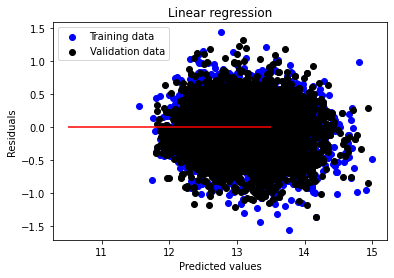

In [21]:
#plot between predicted values and residuals
import matplotlib.pyplot as plt
plt.scatter(train_pre, train_pre - y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre,test_pre - y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

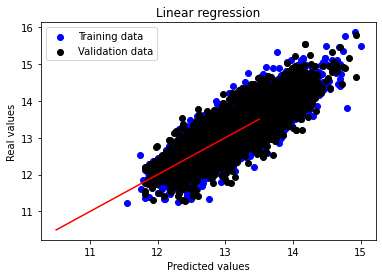

In [22]:
# Plot predictions - Real values
plt.scatter(train_pre, y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [18]:
# from sklearn.svm import SVR
# svr_lin = SVR(kernel='linear', C=100, gamma='auto')
# svr_lin.fit(X_train,y_train)
# test_pre = svr_lin.predict(X_test)
# train_pre = svr_lin.predict(X_train)
# print('rmse on train',rmse_CV_train(svr_lin).mean())
# print('rmse on test',rmse_CV_test(svr_lin).mean())

In [19]:
# #plot between predicted values and residuals
# import matplotlib.pyplot as plt
# plt.scatter(train_pre, train_pre - y_train, c = "blue",  label = "Training data")
# plt.scatter(test_pre,test_pre - y_test, c = "black",  label = "Validation data")
# plt.title("Linear regression")
# plt.xlabel("Predicted values")
# plt.ylabel("Residuals")
# plt.legend(loc = "upper left")
# plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
# plt.show()

In [20]:
# # Plot predictions - Real values
# plt.scatter(train_pre, y_train, c = "blue",  label = "Training data")
# plt.scatter(test_pre, y_test, c = "black",  label = "Validation data")
# plt.title("Linear regression")
# plt.xlabel("Predicted values")
# plt.ylabel("Real values")
# plt.legend(loc = "upper left")
# plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
# plt.show()